In [1]:
import numpy as np
from pathlib import Path
import xarray as xr

In [2]:
data_path = Path("../xorca_test_data/GYRE/")
print(sorted(data_path.glob("*.nc")))

[PosixPath('../xorca_test_data/GYRE/GYRE_5d_00010101_00011230_grid_T.nc'), PosixPath('../xorca_test_data/GYRE/GYRE_5d_00010101_00011230_grid_U.nc'), PosixPath('../xorca_test_data/GYRE/GYRE_5d_00010101_00011230_grid_V.nc'), PosixPath('../xorca_test_data/GYRE/GYRE_5d_00010101_00011230_grid_W.nc'), PosixPath('../xorca_test_data/GYRE/mesh_mask.nc')]


In [3]:
T_files = sorted(data_path.glob("*grid_T.nc"))
U_files = sorted(data_path.glob("*grid_U.nc"))
V_files = sorted(data_path.glob("*grid_V.nc"))
W_files = sorted(data_path.glob("*grid_W.nc"))
mesh_files = sorted(data_path.glob("m*.nc"))

In [4]:
ds_T = xr.open_mfdataset(T_files)
ds_U = xr.open_mfdataset(U_files)
ds_V = xr.open_mfdataset(V_files)
ds_W = xr.open_mfdataset(W_files)
ds_mesh = xr.open_mfdataset(mesh_files)

/home/wrath/miniconda3_20171008/envs/xorca_env/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/home/wrath/miniconda3_20171008/envs/xorca_env/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


In [5]:
def create_coords_ds(mesh_mask, **kwargs):
    """Create a minimal set of coordinates from a mesh-mask dataset.
    This creates `"central"` and `"right"` grid points for the horizontal grid
    and `"central"` and `"left"` grid points in the vertical.
    """
    mesh_mask = mesh_mask.squeeze()
    
    N_z = len(mesh_mask.coords["z"])
    N_y = len(mesh_mask.coords["y"])
    N_x = len(mesh_mask.coords["x"])

    coords = {
        "z_c": (["z_c", ], np.arange(1, N_z + 1),
                {"axis": "Z"}),
        "z_l": (["z_l", ], np.arange(1, N_z + 1) - 0.5,
                {"axis": "Z", "c_grid_axis_shift": - 0.5}),
        "y_c": (["y_c", ], np.arange(1, N_y + 1),
                {"axis": "Y"}),
        "y_r": (["y_r", ], np.arange(1, N_y + 1) + 0.5,
                {"axis": "Y", "c_grid_axis_shift": 0.5}),
        "x_c": (["x_c", ], np.arange(1, N_x + 1),
                {"axis": "X"}),
        "x_r": (["x_r", ], np.arange(1, N_x + 1) + 0.5,
                {"axis": "X", "c_grid_axis_shift": 0.5})
    }
    
    coords["lon_cc"] = mesh_mask.glamt.rename({"y": "y_c", "x": "x_c"})
    coords["lon_rc"] = mesh_mask.glamv.rename({"y": "y_r", "x": "x_c"})
    coords["lon_cr"] = mesh_mask.glamu.rename({"y": "y_c", "x": "x_r"})
    coords["lon_rr"] = mesh_mask.glamf.rename({"y": "y_r", "x": "x_r"})

    coords["lat_cc"] = mesh_mask.gphit.rename({"y": "y_c", "x": "x_c"})
    coords["lat_rc"] = mesh_mask.gphiv.rename({"y": "y_r", "x": "x_c"})
    coords["lat_cr"] = mesh_mask.gphiu.rename({"y": "y_c", "x": "x_r"})
    coords["lat_rr"] = mesh_mask.gphif.rename({"y": "y_r", "x": "x_r"})

    coords["depth_c"] = mesh_mask.gdept_1d.rename({"z": "z_c"})
    coords["depth_l"] = mesh_mask.gdepw_1d.rename({"z": "z_l"})
    
    return xr.Dataset(coords=coords)

In [6]:
ds_coords = create_coords_ds(ds_mesh)
ds_coords

<xarray.Dataset>
Dimensions:  (x_c: 32, x_r: 32, y_c: 22, y_r: 22, z_c: 31, z_l: 31)
Coordinates:
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * z_l      (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_r      (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x_r      (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
    lon_cc   (y_c, x_c) float32 dask.array<shape=(22, 32), chunksize=(22, 32)>
    lon_rc   (y_r, x_c) float32 dask.array<shape=(22, 32), chunksize=(22, 32)>
    lon_cr   (y_c, x_r) float32 dask.array<shape=(22, 32), chunksize=(22, 32)>
    lon_rr   (y_r, x_r) float32 dask.array<shape=(22, 32), chunksize=(22, 32)>
    lat_cc   (y_c, x_c) float32 dask.array<shape=(22, 32), chunksize=(22, 32)>
    lat_rc   (y_r, x_c) float32 

In [7]:
def _arr_is_matching(arr, ref, **kwargs):
    return np.allclose(arr, ref, **kwargs)

In [8]:
def _detect_vertical_grid(ds, ds_coords):
    possible_grids = ["c", "l"]
    for pg in possible_grids:
        for v in filter(lambda s: s.startswith("depth"), ds.coords.keys()):
            if _arr_is_matching(ds_coords[f"depth_{pg}"], ds[v]):
                return pg

In [9]:
def _detect_horizontal_grid(ds, ds_coords):
    possible_grids = ["cc", "cr", "rc", "rr"]
    for pg in possible_grids:
        if (_arr_is_matching(ds_coords[f"lon_{pg}"], ds.nav_lon)
            and _arr_is_matching(ds_coords[f"lat_{pg}"], ds.nav_lat)):
            return pg

In [11]:
def do_not_copy_var(varname, additional_vars=None):
    var_blacklist = ["time_counter", "time_counter_bnds", "nav_lat", "nav_lon",
                     "deptht", "depthu", "depthv", "depthw", "depthf", "x", "y"]
    if additional_vars is not None:
        var_blacklist.extend(additional_vars)
    return varname in var_blacklist

In [12]:
def _maybe_rename(d, rename_dict):
    try:
        return d.rename(rename_dict)
    except ValueError as ve:
        return d

In [13]:
def _maybe_swap_dim(d, old_dim, new_dim, ds_coords):
    try:
        d = d.rename({old_dim: new_dim})
        d.coords[old_dim] = d.coords[new_dim]
        d.coords[new_dim] = ds_coords.coords[new_dim]
        return d
    except ValueError as ve:
        return d

In [14]:
def reset_coords(ds, ds_coords):
    ds_new = xr.Dataset(coords=ds_coords.coords)
    for v in filter(lambda v: not do_not_copy_var(v), ds.data_vars):
        v_new = ds[v]
        v_new = _maybe_rename(v_new, {"time_counter": "t"})
        v_new = _maybe_rename(v_new, {"deptht": f"depth_{_detect_vertical_grid(v_new, ds_coords)}"})
        v_new = _maybe_rename(v_new, {"depthu": f"depth_{_detect_vertical_grid(v_new, ds_coords)}"})
        v_new = _maybe_rename(v_new, {"depthv": f"depth_{_detect_vertical_grid(v_new, ds_coords)}"})
        v_new = _maybe_rename(v_new, {"depthw": f"depth_{_detect_vertical_grid(v_new, ds_coords)}"})
        v_new = _maybe_rename(v_new, {"y": f"y_{_detect_horizontal_grid(v_new, ds_coords)[0]}"})
        v_new = _maybe_rename(v_new, {"x": f"x_{_detect_horizontal_grid(v_new, ds_coords)[1]}"})
        v_new = _maybe_swap_dim(v_new, "depth_c", "z_c", ds_coords)
        v_new = _maybe_swap_dim(v_new, "depth_l", "z_l", ds_coords)
        try:
            v_new = v_new.drop(["nav_lon", "nav_lat"])
        except AttributeErroras as ae:
            pass
        ds_new[v_new.name] = v_new
    return ds_new

In [15]:
ds_T_new = reset_coords(ds_T, ds_coords)
ds_U_new = reset_coords(ds_U, ds_coords)
ds_V_new = reset_coords(ds_V, ds_coords)
ds_W_new = reset_coords(ds_W, ds_coords)

In [16]:
ds_new = xr.merge((ds_T_new, ds_U_new, ds_V_new, ds_W_new))

In [17]:
ds_new.y_c.attrs["axis"] = "Y"
ds_new.x_c.attrs["axis"] = "X"

In [18]:
ds_new

<xarray.Dataset>
Dimensions:   (t: 72, x_c: 32, x_r: 32, y_c: 22, y_r: 22, z_c: 31, z_l: 31)
Coordinates:
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    depth_c   (z_c) float64 dask.array<shape=(31,), chunksize=(31,)>
    depth_l   (z_l) float64 dask.array<shape=(31,), chunksize=(31,)>
    lat_cc    (y_c, x_c) float32 dask.array<shape=(22, 32), chunksize=(22, 32)>
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
    lat_rc    (y_r, x_c) float32 dask.array<shape=(22, 32), chunksize=(22, 32)>
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
    lat_cr    (y_c, x_r) float32 dask.array<shape=(22, 32), chunksize=(22, 32)>
    lat_rr    (y_r, x_r) float32 dask.array<shape=(22, 32), chunksize=(22, 32)>
    lon_cc    (y_c, x_c) float32 dask.array<shape=(22, 32), chunksize=(22, 32)>
    lon_rc    (y_r, x_c) float32 dask.

In [19]:
from xgcm import Grid

In [20]:
grid = Grid(ds_new, periodic=False)

In [21]:
grid

<xgcm.Grid>
X Axis (not periodic):
  * center   x_c (32) --> right
  * right    x_r (32) --> center
T Axis (not periodic):
  * center   t (72)
Z Axis (not periodic):
  * center   z_c (31) --> left
  * left     z_l (31) --> center
Y Axis (not periodic):
  * center   y_c (22) --> right
  * right    y_r (22) --> center

In [22]:
U_cc = grid.interp(ds_new.vozocrtx, "X", to="center", boundary="fill")
V_cc = grid.interp(ds_new.vomecrty, "Y", to="center", boundary="fill")

In [23]:
speed = (U_cc ** 2 + V_cc ** 2) ** 0.5
speed

<xarray.DataArray (t: 72, z_c: 31, y_c: 22, x_c: 32)>
dask.array<shape=(72, 31, 22, 32), dtype=float32, chunksize=(72, 31, 1, 1)>
Coordinates:
  * t        (t) object    1-01-03 12:00:00    1-01-08 12:00:00 ...
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

In [24]:
%matplotlib inline

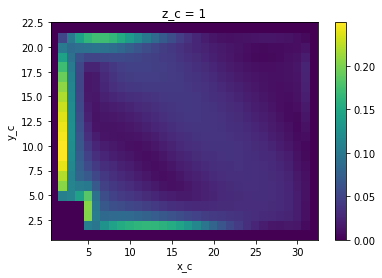

In [25]:
speed.mean("t").isel(z_c=0).plot();